In [7]:
import numpy as np
import matplotlib.pyplot as plt
from random import *
import math
import numba
import scipy.stats

In [8]:
num_sims = 10  # One Example
nf = float(num_sims)

dt = 0.02               # timestep Delta t
n = 10 # number of oscs
t_ini = 0               # starttime
t_end = 20.0           # endtime
n_stp = int(round((t_end-t_ini)/dt)) # step number

kappa, gamma, chi = 10,1,1

# s[i][t][0,1,2]
t = np.arange(t_ini, t_end + 0.5*dt, dt)

# np.savetxt("p.txt", p, fmt='%.18e', delimiter=',')
# p = np.loadtxt("p.txt", delimiter=",")

tmp_p = np.zeros(n)
for i in range(0,n): tmp_p[i] = 1 # random()
p = np.zeros((n,n))

for i in range(0,n):
    for j in range(0,n):
        p[i][j] = tmp_p[i]*tmp_p[j]

sum_p = 0.0
for i in range(0,n): sum_p += tmp_p[i]

x_in = np.zeros((n,3))
s_in = np.zeros((n,3))
v_in = np.zeros((n,3))

x_in = np.loadtxt("x_in.txt",dtype=np.float64,delimiter=",")
s_in = np.loadtxt("s_in.txt",dtype=np.float64,delimiter=",")
v_in = np.loadtxt("v_in.txt",dtype=np.float64,delimiter=",")

# ff = lambda x : 2*x-1

# for i in range(0,n): # x[index][time][coord]
#     x_in[i][0] = uniform(-1,1)
#     x_in[i][1] = uniform(-1,1)
#     x_in[i][2] = uniform(-1,1)
#     s_in[i][0] = uniform(-1,1)
#     s_in[i][1] = uniform(-1,1)
#     s_in[i][2] = uniform(-1,1)
#     v_in[i][0] = ff(randint(0,1))
#     v_in[i][1] = ff(randint(0,1))
#     v_in[i][2] = ff(randint(0,1))
#     print(v_in[i])

#     v_in[i] /= np.linalg.norm(v_in[i])
#     s_in[i] = s_in[i] - (np.inner(v_in[i],s_in[i]))*v_in[i]


In [9]:
# np.savetxt("x_in.txt", x_in, fmt='%.18e', delimiter=',')
# np.savetxt("s_in.txt", s_in, fmt='%.18e', delimiter=',')
# np.savetxt("v_in.txt", v_in, fmt='%.18e', delimiter=',')

In [10]:
@numba.njit

def dW(delta_t): # dW: Random process
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))

def init(x_in,s_in,v_in):
    x = np.zeros((n,(n_stp + 1),3))
    s = np.zeros((n,(n_stp + 1),3))
    v = np.zeros((n,(n_stp + 1),3))

    for i in range(0,n):
        x[i,0,:] = x_in[i]
        s[i,0,:] = s_in[i]
        v[i,0,:] = v_in[i]
    return(x,s,v)

def SIS_first(sigma,x,s,v,model_num):
    s_int = np.zeros((n,n_stp+1))
    for i in range(1, n_stp + 1): #iterate for time
        x[:,i] = x[:,i-1] + dt * v[:,i-1]
        for j in range(0,n): # iterate for osc
            tmp_v1 = (sum_p/n) * np.average(v[:,i-1,:], axis=0, weights=tmp_p) # vc
            tmp_v2 = (kappa*tmp_p[j])*np.cross(v[j][i-1],tmp_v1) - (gamma/chi)*s[j][i-1] # coeff of dt
            if model_num==1:
                tmp_v3 = (sigma/chi) * s[j][i-1] # coeff of dw
                tmp_v4 = ((sigma/chi)**2) * s[j][i-1] #coeff of dw**2 - dt
            else:
                tmp_v3 = sigma*np.cross(v[j][i-1],tmp_v1)
                tmp_v4 = np.zeros(3)
            dw_ = dW(dt)
            v[j][i] = v[j][i-1] + (1/chi) * dt * np.cross(s[j][i-1],v[j][i-1])
            v[j][i] /= np.linalg.norm(v[j][i])

            s[j][i] = s[j][i-1] + dt*tmp_v2 + dw_*tmp_v3 + 0.5*(dw_**2-dt)*tmp_v4
            s_int[j][i] = np.linalg.norm(s[j][i])
    return(x,s,v,s_int)

def run_sims(x_in,s_in,v_in,sigma,num_sims,model_num):
    x1 = np.zeros((n,(n_stp + 1),3))
    s1 = np.zeros((n,(n_stp + 1),3))
    v1 = np.zeros((n,(n_stp + 1),3))
    s_norm1 = np.zeros((n,(n_stp + 1)))
    s_norm_mean1 = np.zeros((n_stp + 1))
    v_c1 = np.zeros(((n_stp + 1),3))
    v_ic_norm1 = np.zeros((n,(n_stp + 1)))
    v_eng1 = np.zeros(n_stp + 1) # 1/n^2 sum pij |vi-vj|^2
    v_ic1 = np.zeros((n,(n_stp + 1),3)) # vi cross vc

    s_norm_mean2 = np.zeros((n_stp + 1)) # sample of \frac{n}{n-1}(E(X^2)-E(X)^2)
    v_eng2 = np.zeros(n_stp + 1) # sample of \frac{n}{n-1}(E(X^2)-E(X)^2)
    s_int1 = np.zeros((n,n_stp+1))
    var_es = np.zeros(n_stp+1)

    if sigma==0: 
        num_sims=2
    for ii in range(0,num_sims):
        x,s,v = init(x_in,s_in,v_in) # initialize
        (x,s,v,s_int)=SIS_first(sigma,x,s,v,model_num) # solve ODE
        # else : (x,s,v,s_int)=SIS_second(sigma,x,s,v) # solve ODE
        x1 += x
        s1 += s
        v1 += v
        s_int1 += s_int

        s_norm = np.zeros((n,(n_stp + 1)))
        s_norm_mean = np.zeros((n_stp + 1))

        for j in range(0,n_stp + 1):
            for i in range(0,n):
                s_norm[i][j] += np.linalg.norm(s[i][j])**2
                s_norm_mean[j] += np.linalg.norm(s[i][j])**2
        s_norm_mean /= n

        s_norm1 += s_norm
        s_norm_mean1 += s_norm_mean

        v_c = np.zeros(((n_stp + 1),3))
        v_eng = np.zeros(n_stp + 1) # 1/n^2 sum pij |vi-vj|^2

        for j in range(0,n_stp + 1):
            for i in range(0,n):
                v_c[j] += tmp_p[i]*v[i][j]
            v_c[j] /= n

            if (ii==0):
                for i in range(0,n):
                    v_ic1[i][j] = np.cross(v[i][j],v_c[j])
                    v_ic_norm1[i][j] = np.linalg.norm(v_ic1[i][j])**2

            for i in range(0,n):
                for k in range(0,n):
                    v_eng[j] += p[i][k] * (np.linalg.norm(v[i][j]-v[k][j])**2)

        
        v_eng /= (n**2)
        v_eng1 += v_eng
        v_c1 += v_c  

        s_norm_mean2 += s_norm_mean**2
        v_eng2 += v_eng**2 
        var_es += (v_eng + (2/(chi*kappa))*s_norm_mean)**2

    s_norm_mean2 /= num_sims
    v_eng2 /= num_sims

    x1 /= num_sims
    s1 /= num_sims
    v1 /= num_sims

    s_norm1 /= num_sims
    s_norm_mean1 /= num_sims
    s_int1 /= num_sims

    v_c1 /= num_sims
    v_eng1 /= num_sims
    var_es /= num_sims

    s_norm_mean2 = np.sqrt((1/(nf-1))*np.abs(s_norm_mean2 - s_norm_mean1**2))
    v_eng2 = np.sqrt((1/(nf-1))*np.abs(v_eng2 - v_eng1**2))
    var_es = np.sqrt((1/(nf-1))*np.abs(var_es - (v_eng1 + (2/(chi*kappa))*s_norm_mean1)**2))
    s_int1 *= 1/chi

    return (x1,s1,v1,s_norm_mean1, v_eng1, s_norm_mean2, v_eng2, s_int1, var_es)


In [11]:
plt.rcParams['text.usetex'] = True

In [12]:
#sig = [0,1,1.5] # for model A
sig = [0,2,3,5] # for model B
s_norm_mean1 = np.zeros((len(sig), n_stp + 1))
s_norm_mean2 = np.zeros((len(sig), n_stp + 1))
v_eng1 = np.zeros((len(sig), n_stp + 1)) # 1/n^2 sum pij |vi-vj|^2
v_eng2 = np.zeros((len(sig), n_stp + 1))
s_int1 = np.zeros((len(sig), n, n_stp+1))
var_es = np.zeros((len(sig), n_stp + 1))

x1 = np.zeros((len(sig), n, (n_stp + 1),3))
s1 = np.zeros((len(sig), n, (n_stp + 1),3))
v1 = np.zeros((len(sig), n, (n_stp + 1),3))
s_norm1 = np.zeros((n,(n_stp + 1)))
v_c1 = np.zeros(((n_stp + 1),3))

model_num = 2 # 1 for model A, otherwise model B
for i in range(0,len(sig)):
    (x1[i],s1[i],v1[i],s_norm_mean1[i], v_eng1[i], s_norm_mean2[i], v_eng2[i], s_int1[i], var_es[i]) = run_sims(x_in,s_in,v_in,sig[i],num_sims,model_num)

s_int1 = np.log10(s_int1)


C:\Users\tove1\AppData\Local\Temp\ipykernel_11064\2239932355.py:20: RuntimeWarning: divide by zero encountered in log10
  s_int1 = np.log10(s_int1)


C:\Users\tove1\AppData\Local\Temp\ipykernel_11064\2190390960.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_5.set_xticklabels([r'$%0.1f$' % x for x in ax_5.get_xticks()])
C:\Users\tove1\AppData\Local\Temp\ipykernel_11064\2190390960.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_5.set_yticklabels([r'$%0.1f$' % x for x in ax_5.get_yticks()])
C:\Users\tove1\AppData\Local\Temp\ipykernel_11064\2190390960.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_5.set_xticklabels([r'$%0.1f$' % x for x in ax_5.get_xticks()])
C:\Users\tove1\AppData\Local\Temp\ipykernel_11064\2190390960.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_5.set_yticklabels([r'$%0.1f$' % x for x in ax_5.get_yticks()])
C:\Users\tove1\AppData\Local\Temp\ipykernel_11064\2190390960.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xt

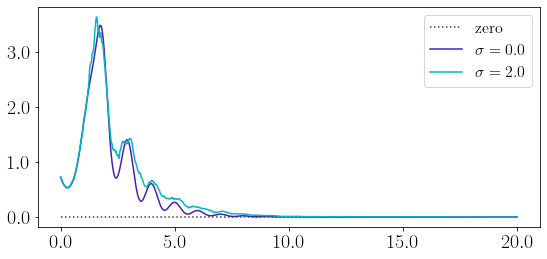

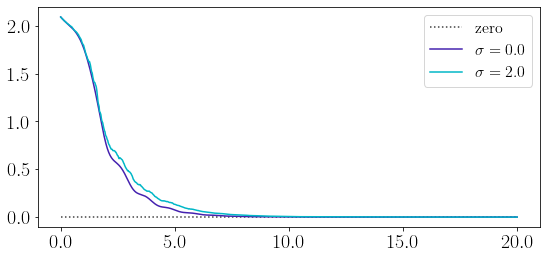

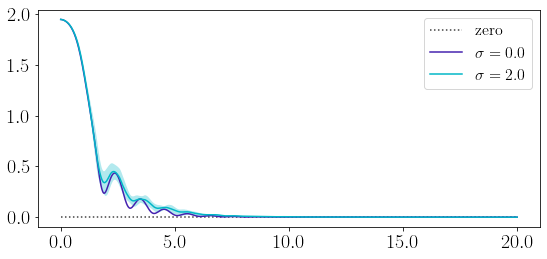

In [18]:
title = 'Model(1.9)' # (1.8 or 1.9)
cnt=1
plt.rcParams.update({'font.size': 20})

fig_1, ax_1 = plt.subplots(figsize=(8, 4))
fig_2, ax_2 = plt.subplots(figsize=(8, 4))
fig_4, ax_4 = plt.subplots(figsize=(8, 4))

ax_1.plot(t,np.zeros(len(t)),label=r'$\textrm{zero}$',linestyle=':',c="#404040")
ax_2.plot(t,np.zeros(len(t)),label=r'$\textrm{zero}$',linestyle=':',c="#404040")
ax_4.plot(t,np.zeros(len(t)),label=r'$\textrm{zero}$',linestyle=':',c="#404040")


colors = ["#4421af", "#1a53ff", "#0d88e6", "#00b7c7", "#5ad45a", "#8be04e"]

mod = [0,1] # we can modify range of i
q_val = 1.0 - 0.025
q_v = scipy.stats.t.ppf(q=q_val,df=num_sims-1)

for i in mod: 
    color = colors[3*i] # 0 or 3*i
    ax_1.plot(t,(s_norm_mean1[i]), label=r'$\sigma=%0.1f$' % sig[i], c=color) # S

    # if sig[i]!=0: # errorbar
    #     ax_1.fill_between(t, s_norm_mean1[i]-q_v*s_norm_mean2[i], s_norm_mean1[i]+q_v*s_norm_mean2[i], alpha=0.3, facecolor=color, linewidth=0)
    # --------------------------------------------------------------------------------
    ax_2.plot(t,(v_eng1[i] + (2/(chi*kappa))*s_norm_mean1[i]), label=r'$\sigma=%0.1f$' % sig[i], c=color) # E + S
    # if sig[i]!=0: # errorbar
    #     ax_2.fill_between(t, (v_eng1[i] + (2/(chi*kappa))*s_norm_mean1[i])-q_v*var_es[i], (v_eng1[i] + (2/(chi*kappa))*s_norm_mean1[i])+q_v*var_es[i], 
    #         alpha=0.3, facecolor=color, edgecolor=color, linewidth=0)

    # --------------------------------------------------------------------------------
    ax_4.plot(t, (v_eng1[i]), label=r'$\sigma=%0.1f$' % sig[i], c=color) # S
    if sig[i]!=0: # errorbar
        ax_4.fill_between(t, v_eng1[i] - q_v*v_eng2[i], v_eng1[i] + q_v*v_eng2[i], 
            alpha=0.3, facecolor=color, edgecolor=color, linewidth=0)
    # --------------------------------------------------------------------------------
    fig_5, ax_5 = plt.subplots(figsize=(8, 4)) # |dot v_i| = |s_i|
    
    for j in range(0,n):
        ax_5.plot(t, s_int1[i,j,:])
    ax_5.set_xticklabels([r'$%0.1f$' % x for x in ax_5.get_xticks()])
    ax_5.set_yticklabels([r'$%0.1f$' % x for x in ax_5.get_yticks()])
    ax_5.locator_params(axis='y', nbins=5)
    
    fig_5.tight_layout()
    fig_5.savefig(('fig_tmp/%s%dsigma=%.1f.pdf' % (title,5,sig[i])))
    plt.close(fig_5)
    #-----------------------------------------------------------------------

ax_1.set_xticklabels([r'$%0.1f$' % x for x in ax_1.get_xticks()])
ax_2.set_xticklabels([r'$%0.1f$' % x for x in ax_2.get_xticks()])
ax_4.set_xticklabels([r'$%0.1f$' % x for x in ax_4.get_xticks()])

ax_1.set_yticklabels([r'$%0.1f$' % x for x in ax_1.get_yticks()])
ax_2.set_yticklabels([r'$%0.1f$' % x for x in ax_2.get_yticks()])
ax_4.set_yticklabels([r'$%0.1f$' % x for x in ax_4.get_yticks()])

ax_1.legend(loc=1, prop={'size': 16})
ax_2.legend(loc=1, prop={'size': 16})
ax_4.legend(loc=1, prop={'size': 16})

fig_1.tight_layout()
fig_2.tight_layout()
fig_4.tight_layout()

# ax_1.semilogy(base=10)
# ax_2.semilogy(base=10)
# ax_4.semilogy(base=10)

fig_1.savefig('fig_tmp/%s%dsigma=%.1f.pdf' % (title,1,sig[mod[-1]]))  
fig_2.savefig('fig_tmp/%s%dsigma=%.1f.pdf' % (title,2,sig[mod[-1]]))  
fig_4.savefig('fig_tmp/%s%dsigma=%.1f.pdf' % (title,4,sig[mod[-1]]))

plt.show()

In [14]:
# fig = plt.figure()
# title = 'Model(1.8)'

# rr = 1
# cc = 5
# test_elev = 30
# test_azim = 0

# fig.set_figheight(4*rr)
# fig.set_figwidth(4*cc)
# cnt=1
# nam_arr = np.arange(0,t_end,2.5)
# ind_arr = np.arange(0,n_stp,n_stp//6, dtype=int)

# for cnt in range(1,cc+1):
#     ax = fig.add_subplot(rr,cc,cnt,projection='3d') # v_c
#     t_fig = plt.figure()
#     t_ax = t_fig.add_subplot(1,1,1,projection='3d')
    
#     ind = int((float(cnt)/float(cc-1))*float(n_stp))

#     ax.set_title(r'$v_i$, time = {x}'.format(x=nam_arr[cnt-1]))
#     t_ax.set_title(r'$v_i$, time = {x}'.format(x=nam_arr[cnt-1]))

#     r = 0.05
#     _u, _v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
#     x = np.cos(_u) * np.sin(_v)
#     y = np.sin(_u) * np.sin(_v)
#     z = np.cos(_v)
#     ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r)
#     t_ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r)

#     for i in range(0,n):
#         tmp_v = np.array(v1[i,ind_arr[cnt-1]])/(0.9*np.linalg.norm(v1[i,ind_arr[cnt-1]]))
#         ax.scatter(tmp_v[0], tmp_v[1], tmp_v[2],s=50, c='red')
#         t_ax.scatter(tmp_v[0], tmp_v[1], tmp_v[2],s=50, c='red')
#     ax.view_init(test_elev,test_azim)
#     t_ax.view_init(test_elev,test_azim)
#     t_fig.savefig('fig/%s%d_sphere.pdf' % (title,cnt))  
#     plt.close(t_fig)

# fig.savefig('fig/%s_sphere_total.pdf' % (title))
# plt.show()

# # --------------------------------------------------------------------------------


In [15]:

'''s_normal = np.zeros((n,(n_stp + 1),3))

for i in range(0,n):
    for j in range(0,n_stp+1):
        s_normal[i][j] = s1[i][j]/np.linalg.norm(s1[i][j]) 

fig = plt.figure()

fig.set_figheight(5)
fig.set_figwidth(10)

ax = fig.add_subplot(1,1,1,projection='3d') # v_i
ax.set_title('s_normed')

for i in range(0,n):
    ax.plot(s_normal[i,:,0],s_normal[i,:,1],s_normal[i,:,2])
'''

"s_normal = np.zeros((n,(n_stp + 1),3))\n\nfor i in range(0,n):\n    for j in range(0,n_stp+1):\n        s_normal[i][j] = s1[i][j]/np.linalg.norm(s1[i][j]) \n\nfig = plt.figure()\n\nfig.set_figheight(5)\nfig.set_figwidth(10)\n\nax = fig.add_subplot(1,1,1,projection='3d') # v_i\nax.set_title('s_normed')\n\nfor i in range(0,n):\n    ax.plot(s_normal[i,:,0],s_normal[i,:,1],s_normal[i,:,2])\n"

In [16]:
# np.savetxt("x1.txt", x1, fmt='%.18e', delimiter=',')
# np.savetxt("s1.txt", s1, fmt='%.18e', delimiter=',')
# np.savetxt("v1.txt", v1, fmt='%.18e', delimiter=',')
# np.savetxt("s_norm_mean1.txt", s_norm_mean1, fmt='%.18e', delimiter=',')
# np.savetxt("s_norm_mean2.txt", s_norm_mean2, fmt='%.18e', delimiter=',')
# np.savetxt("v_eng1.txt", v_eng1, fmt='%.18e', delimiter=',')
# np.savetxt("v_eng2.txt", v_eng2, fmt='%.18e', delimiter=',')
# np.savetxt("s_int1.txt", s_int1, fmt='%.18e', delimiter=',')
# np.savetxt("var_es.txt", var_es, fmt='%.18e', delimiter=',')


# coord_lim = 1 #limiter
# ax.set_xlim(-coord_lim, coord_lim)
# ax.set_ylim(-coord_lim, coord_lim)
# ax.set_zlim(-coord_lim, coord_lim)
# ax.view_init(elev=20., azim=-35)


In [17]:
"""from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')
   
spd = 2
myvar = count(0, spd*dt)

def animate(i):
    graph._offsets3d = (s_normal[:,spd*i,0],s_normal[:,spd*i,1],s_normal[:,spd*i,2])

graph = ax.scatter(s_normal[:,0,0],s_normal[:,0,1],s_normal[:,0,2])

anim = FuncAnimation(fig, animate, interval=5, frames=n_stp//spd)
anim.save('a2.mp4', writer='ffmpeg', fps=60)"""


"from mpl_toolkits.mplot3d import Axes3D\n\nfig = plt.figure()\nax = plt.axes(projection='3d')\n   \nspd = 2\nmyvar = count(0, spd*dt)\n\ndef animate(i):\n    graph._offsets3d = (s_normal[:,spd*i,0],s_normal[:,spd*i,1],s_normal[:,spd*i,2])\n\ngraph = ax.scatter(s_normal[:,0,0],s_normal[:,0,1],s_normal[:,0,2])\n\nanim = FuncAnimation(fig, animate, interval=5, frames=n_stp//spd)\nanim.save('a2.mp4', writer='ffmpeg', fps=60)"